In [1]:
from datetime import datetime, timedelta
import logging
import pandas as pd
import numpy as np

from prometheus_api_client import MetricRangeDataFrame, PrometheusConnect

import sklearn
from sklearn.datasets import fetch_california_housing

from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.neural_network import MLPRegressor

from xgboost import XGBRegressor


from sklearn.pipeline import make_pipeline
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
from sklearn.utils import Bunch

import matplotlib.pyplot as plt

In [2]:
PROM_URL = "http://localhost:9090"
RATE_INTERVAL = "20s"

METRIC_BPF_CPU_TIME = "kepler_process_bpf_cpu_time_ms_total"
QUERY_BPF_CPU_TIME = "sum(rate(kepler_process_bpf_cpu_time_ms_total{}[{}]))"
COLUMNS_COMMAND_PID = ['command', 'pid']

METRIC_CPU_INSTRUCTIONS = "kepler_process_cpu_instructions_total"
QUERY_CPU_INSTRUCTIONS = "sum(rate(kepler_process_cpu_instructions_total{}[{}]))"
METRIC_CPU_TIME = "cpu_time"

METRIC_CPU_CYCLES = "kepler_process_cpu_cycles_total"
QUERY_CPU_CYCLES = "sum(rate(kepler_process_cpu_cycles_total{}[{}]))"
METRIC_CPU_CYCLES = "cpu_cycles"

METRIC_PKG_JOULES_TOTAL = "kepler_process_package_joules_total"
QUERY_KEPLER_PKG_JOULES_TOTAL = "rate(kepler_process_package_joules_total{}[{}])"

METRIC_NODE_RAPL_PKG_JOULES_TOTAL = "node_rapl_package_joules_total"
QUERY_NODE_RAPL_PKG_JOULES_TOTAL = "sum(rate(node_rapl_package_joules_total{}[{}]))"
LABEL_RAPL_PATH = "/host/sys/class/powercap/intel-rapl:0"

METRIC_NODE_CPU_SCALING_FREQUENCY_HERTZ = "node_cpu_scaling_frequency_hertz"
QUERY_NODE_CPU_SCALING_FREQUENCY_HERTZ = "sum(node_cpu_scaling_frequency_hertz{})"
LABEL_RAPL_PATH = "/host/sys/class/powercap/intel-rapl:0"


METRIC_UP = "up"
logging.basicConfig(level=logging.ERROR)

In [3]:
def train_lr(data):
    X = data.drop('PRICE', axis=1)
    y = data['PRICE']
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    model = LinearRegression()
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    print(f"Mean Squared Error: {mse}")
    print(f"R^2 Score: {r2}")
    print("Coefficients:")
    for feature, coef in zip(X.columns, model.coef_):
        print(f"{feature}: {coef}")
    return model

In [4]:
def test_california_housing():
    california: Bunch = fetch_california_housing()
    data: pd.DataFrame = pd.DataFrame(california.data, columns=california.feature_names)
    data['PRICE'] = california.target
    print(data.head())
    data.plot()
    plt.show()
    model = train_lr(data)
    return model

In [5]:
def fetch_prometheus_data(start_time, end_time, query, rename_value_column, columns=[], label_config: dict = None):
    try:
        prom = PrometheusConnect(url=PROM_URL, disable_ssl=True)
        if label_config:
            label_list = [str(key + "=~" + "'" + label_config[key] + "'") for key in label_config]
            labels = "{" + ",".join(label_list) + "}"
        else:
            labels = ""
        if "rate(" in query:
            query = query.format(labels, RATE_INTERVAL)
        else:
            query = query.format(labels)
#        query = query.format(labels, RATE_INTERVAL)
        metric_data = prom.custom_query_range(query=query, start_time=start_time, end_time=end_time, step="1s")
        if not metric_data:
            raise ValueError(f"No data found for metric: {query}")
        #print(metric_data)
        metric_df = MetricRangeDataFrame(data=metric_data, columns=(columns + ['timestamp', 'value']), ts_as_datetime=False)
        metric_df.index = metric_df.index.astype('int64')
        metric_df.rename(columns={'value': rename_value_column}, inplace=True)
        metric_df = metric_df.sort_values(by='timestamp')
        return metric_df
    except Exception as e:
        import traceback
        print(f"An error occurred: {e}")
        traceback.print_exc()
        return pd.DataFrame()

In [6]:
def printDF(df: pd.DataFrame):
    df_name = df.attrs['name']
    print(f"{df_name} shape: {df.shape}, Columns: {df.columns}, Index={df.index}")
    print(df)

## Start and end time

In [7]:
end_time = datetime.now()
#end_time = datetime.fromtimestamp(1726381808)

duration_5_min = 1000 * 60 * 5
duration_10_min = 1000 * 60 * 10
duration_20_min = 1000 * 60 * 20
duration_45_min = 1000 * 60 * 45
duration_1_hour = 1000 * 60 * 60
duration_2_hour = duration_1_hour * 2


duration = duration_2_hour

start_time = end_time - timedelta(milliseconds=duration)


## Query prometheus and get the following data frames
 - `bpf_cpu_time_df`: bpf cpu time for all processes, from kepler
 - `rapl_pkg_joules_df` : rapl power from Node Exporter
 - `kepler_pkg_joules_df` : kepler process package joules
 - `cpu_inst_df` : cpu instructions for all processes, from kepler

In [8]:
bpf_cpu_time_df = fetch_prometheus_data(
    start_time=start_time,
    end_time=end_time,
    query=QUERY_BPF_CPU_TIME,
    rename_value_column='bpf_cpu_time',
    #label_config={"command": ".*stress.*"},
    #columns=COLUMNS_COMMAND_PID
    )
bpf_cpu_time_df.attrs = {"name": "bpf_cpu_time_df"}
#printDF(bpf_cpu_time_df)

In [9]:
rapl_pkg_joules_df = fetch_prometheus_data(
    start_time=start_time,
    end_time=end_time,
    query=QUERY_NODE_RAPL_PKG_JOULES_TOTAL,
    rename_value_column='rapl_pkg_joules',
    label_config={"path": LABEL_RAPL_PATH})
rapl_pkg_joules_df.attrs = {"name": "rapl_pkg_joules_df"}
#printDF(rapl_pkg_joules_df)

In [10]:
kepler_pkg_joules_df = fetch_prometheus_data(
    start_time=start_time,
    end_time=end_time,
    query=QUERY_KEPLER_PKG_JOULES_TOTAL,
    rename_value_column='kepler_pkg_joules',
    #label_config={"command": ".*stress.*"},
    columns=COLUMNS_COMMAND_PID)
kepler_pkg_joules_df.attrs = {"name": "kepler_pkg_joules_df"}
#printDF(kepler_pkg_joules_df)

In [11]:
cpu_inst_df = fetch_prometheus_data(
    start_time=start_time,
    end_time=end_time,
    query=QUERY_CPU_INSTRUCTIONS,
    rename_value_column='cpu_instructions',
    #label_config={"command": ".*stress.*"},
    columns=COLUMNS_COMMAND_PID)
cpu_inst_df.attrs = {"name": "cpu_inst_df"}
#printDF(cpu_inst_df)

In [12]:
cpu_cycles_df = fetch_prometheus_data(
    start_time=start_time,
    end_time=end_time,
    query=QUERY_CPU_CYCLES,
    rename_value_column='cpu_cycles',
    #label_config={"command": ".*stress.*"},
    columns=COLUMNS_COMMAND_PID)
cpu_cycles_df.attrs = {"name": "cpu_cycles_df"}    
#printDF(cpu_cycles_df)

In [13]:
cpu_scaling_freq_df = fetch_prometheus_data(
    start_time=start_time,
    end_time=end_time,
    query=QUERY_NODE_CPU_SCALING_FREQUENCY_HERTZ,
    rename_value_column='cpu_scaling_freq',
    #label_config={"command": ".*stress.*"},
    columns=COLUMNS_COMMAND_PID)
cpu_scaling_freq_df.attrs = {"name": "cpu_scaling_freq_df"}    
#printDF(cpu_scaling_freq_df)

## Sum the bpf time to get total bpf time, and the get bpf_ratio for each context switch

In [14]:
bpf_cpu_time_df.head()

,bpf_cpu_time
timestamp,
1726478548,1093.466667
1726478549,1093.466667
1726478550,1093.466667
1726478551,1093.466667
1726478552,1102.866667


In [15]:
rapl_pkg_joules_df.head()

,rapl_pkg_joules
timestamp,
1726478548,3.849071
1726478549,3.849071
1726478550,3.849071
1726478551,4.087494
1726478552,4.087494


## Plot 'em

<Axes: xlabel='timestamp'>

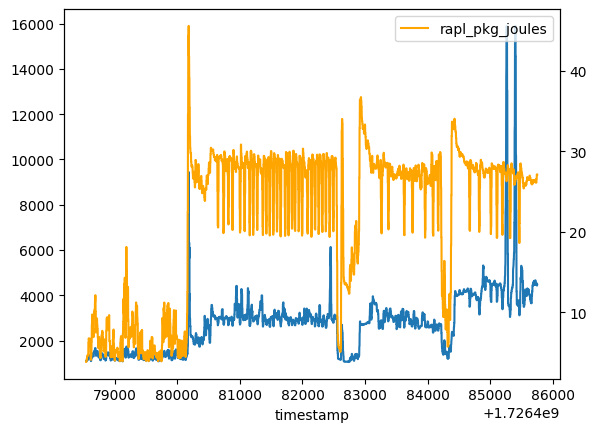

In [16]:
ax = bpf_cpu_time_df['bpf_cpu_time'].plot(label='bpf_cpu_time')
ax2 = ax.twinx()
rapl_pkg_joules_df.plot(ax = ax2, color='orange', label='rapl_pkg_joules')
#kepler_pkg_joules_df.plot(ax = ax2, color='green', label='kepler_pkg_joules')

<Axes: xlabel='timestamp'>

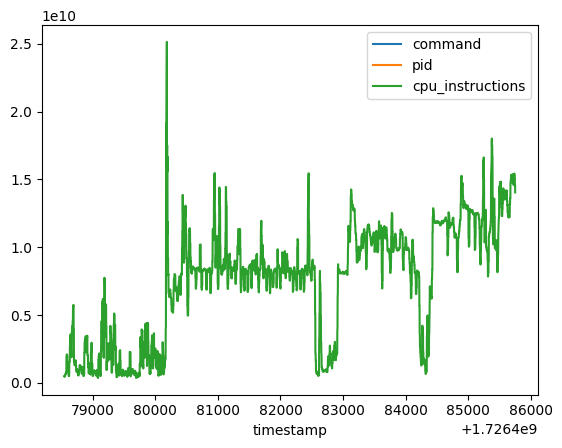

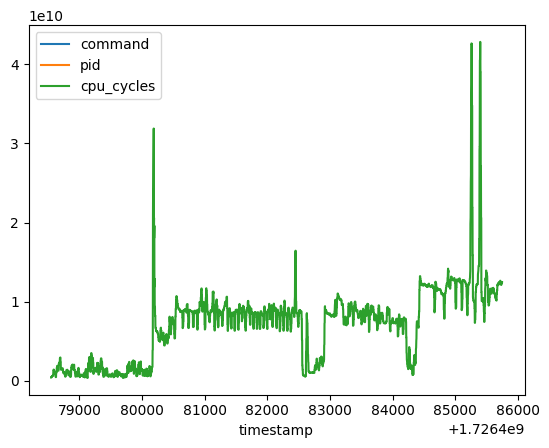

In [17]:
cpu_inst_df.plot()
cpu_cycles_df.plot()
#cpu_scaling_freq_df
#plt.show()

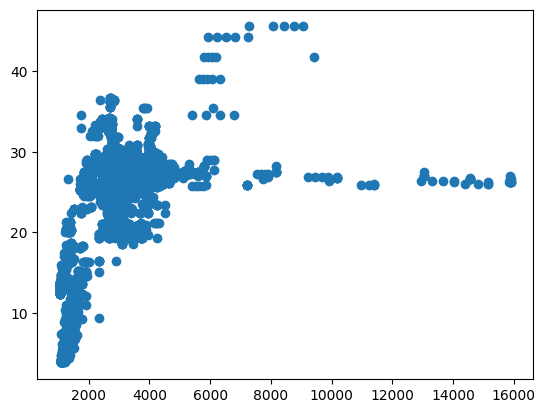

In [18]:
plt.scatter(x = bpf_cpu_time_df['bpf_cpu_time'], y = rapl_pkg_joules_df['rapl_pkg_joules'])

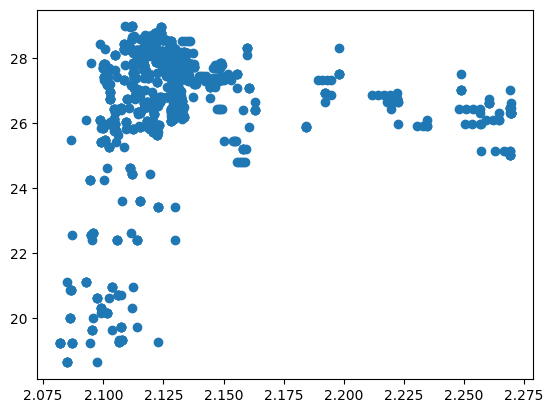

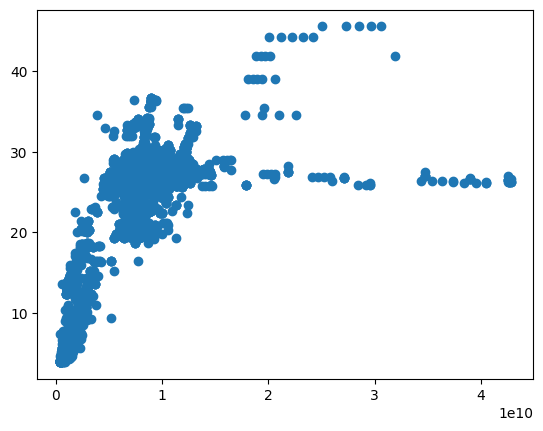

In [19]:
plt.scatter(x = cpu_cycles_df['cpu_cycles'], y = rapl_pkg_joules_df['rapl_pkg_joules'])

# Prepare input data for training

In [20]:
#X = pd.DataFrame(bpf_cpu_time_df['bpf_cpu_time'], cpu_inst_df['cpu_instructions'])
#X = bpf_cpu_time_df.drop(['command', 'pid', 'bpf_cpu_time_ratio'], axis =1)
X = bpf_cpu_time_df
X['cpu_instructions'] = cpu_inst_df['cpu_instructions']
X['cpu_cycles'] = cpu_cycles_df['cpu_cycles']
X['cpu_scaling_freq'] = cpu_scaling_freq_df['cpu_scaling_freq']
y = pd.DataFrame(rapl_pkg_joules_df['rapl_pkg_joules'])

In [21]:
X.sample

<bound method NDFrame.sample of             bpf_cpu_time  cpu_instructions    cpu_cycles  cpu_scaling_freq
timestamp                                                                 
1726478548   1093.466667      4.933616e+08  4.255807e+08      1.415617e+10
1726478549   1093.466667      4.933616e+08  4.255807e+08      1.415617e+10
1726478550   1093.466667      4.933616e+08  4.255807e+08      1.415617e+10
1726478551   1093.466667      4.933616e+08  4.255807e+08      2.100030e+10
1726478552   1102.866667      4.510899e+08  4.955325e+08      2.100030e+10
...                  ...               ...           ...               ...
1726485744   4430.666667      1.465535e+10  1.232784e+10      4.801782e+10
1726485745   4430.666667      1.465535e+10  1.232784e+10      4.801782e+10
1726485746   4430.666667      1.465535e+10  1.232784e+10      4.583438e+10
1726485747   4465.733333      1.403729e+10  1.246804e+10      4.583438e+10
1726485748   4465.733333      1.403729e+10  1.246804e+10      4.5834

In [22]:
X.columns

Index(['bpf_cpu_time', 'cpu_instructions', 'cpu_cycles', 'cpu_scaling_freq'], dtype='object')

In [23]:
X.shape

(7201, 4)

In [24]:
y.sample

<bound method NDFrame.sample of             rapl_pkg_joules
timestamp                  
1726478548         3.849071
1726478549         3.849071
1726478550         3.849071
1726478551         4.087494
1726478552         4.087494
...                     ...
1726485744        27.137764
1726485745        27.137764
1726485746        27.102791
1726485747        27.102791
1726485748        27.102791

[7201 rows x 1 columns]>

# Split into training and test data

In [25]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(X_train.columns)
X_train.sample

Index(['bpf_cpu_time', 'cpu_instructions', 'cpu_cycles', 'cpu_scaling_freq'], dtype='object')


<bound method NDFrame.sample of             bpf_cpu_time  cpu_instructions    cpu_cycles  cpu_scaling_freq
timestamp                                                                 
1726484558   4069.400000      1.164988e+10  1.195783e+10      4.256563e+10
1726481598   3136.200000      8.814649e+09  7.977727e+09      4.833584e+10
1726480756   2988.873910      8.213901e+09  8.981296e+09      5.280061e+10
1726479971   1430.133333      2.728712e+09  1.865296e+09      1.470623e+10
1726478670   1468.533333      3.740442e+09  2.109877e+09      1.560470e+10
...                  ...               ...           ...               ...
1726482320   2613.800000      6.883205e+09  6.333992e+09      4.625661e+10
1726483739   2823.266667      9.646862e+09  8.012820e+09      4.656037e+10
1726483774   3150.800000      1.199251e+10  9.099422e+09      4.158855e+10
1726483938   3124.400000      1.108818e+10  8.979996e+09      5.124761e+10
1726479408   1477.200000      1.373477e+09  1.498365e+09      2.1922

# Linear Regression

In [26]:
lr_model = LinearRegression()
lr_model.fit(X_train, y_train)
y_pred = lr_model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Mean Squared Error: {mse}")
print(f"R^2 Score: {r2}")
print("Coefficients:")
for feature, coef in zip(X.columns, lr_model.coef_):
    print(f"{feature}: {coef}")

Mean Squared Error: 3.099360856052907
R^2 Score: 0.9647930955476846
Coefficients:
bpf_cpu_time: [-1.53304603e-02  2.06699109e-10  5.77697674e-09  7.88421610e-11]


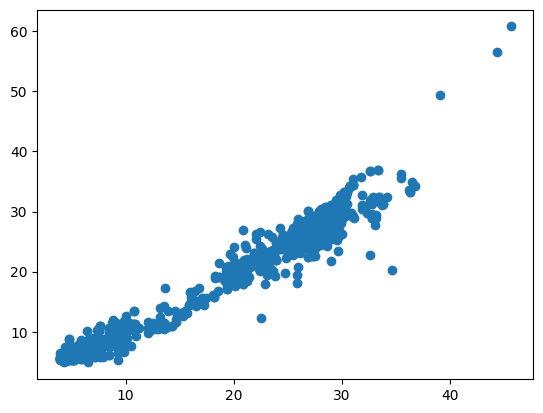

In [27]:
plt.scatter(x = y_test, y = y_pred)

# Polynomial Regression

In [28]:
poly = PolynomialFeatures(degree=2)
pr_model = make_pipeline(poly, LinearRegression())
pr_model.fit(X_train, y_train)

y_pred = pr_model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Mean Squared Error: {mse}")
print(f"R^2 Score: {r2}")
#print(model)
#print("Coefficients:")
#for feature, coef in zip(X.columns, model.coef_):
#    print(f"{feature}: {coef}")


Mean Squared Error: 2.286660468504973
R^2 Score: 0.9740248908182743


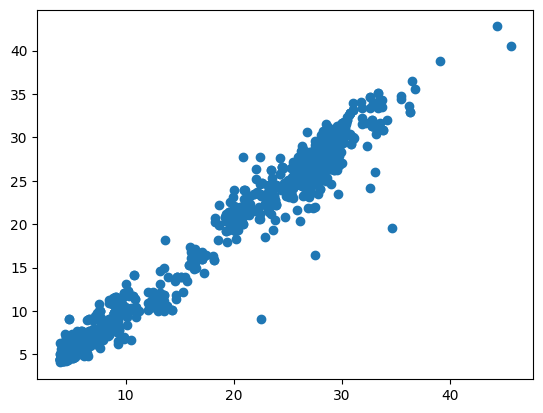

In [29]:
plt.scatter(x = y_test, y = y_pred)

#  Logarithmic Transformation

In [30]:
# Apply log transformation to the target variable
X_train_log = np.log(X_train)

# Fit a Linear Regression model
lt_model = LinearRegression()
lt_model.fit(X_train_log, y_train)

# Predict and reverse log transformation
X_test_log = np.log(X_test)
y_pred = lt_model.predict(X_test_log)
#y_pred_log = lt_model.predict(X_test)
#y_pred = np.exp(y_pred_log)

mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Mean Squared Error: {mse}")
print(f"R^2 Score: {r2}")



Mean Squared Error: 6.8565282021969844
R^2 Score: 0.9221138988001614


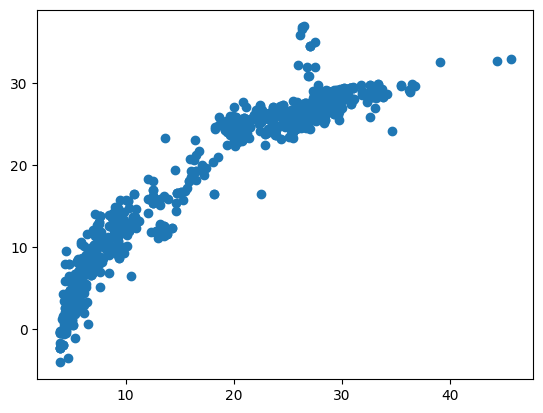

In [31]:
plt.scatter(x = y_test, y = y_pred)

# Decision Trees

In [32]:
dt_model = DecisionTreeRegressor(max_depth=5)  # Tune depth as necessary
dt_model.fit(X_train, y_train)

y_pred = dt_model.predict(X_test)

mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Mean Squared Error: {mse}")
print(f"R^2 Score: {r2}")

Mean Squared Error: 3.29669740590901
R^2 Score: 0.9625514691677924


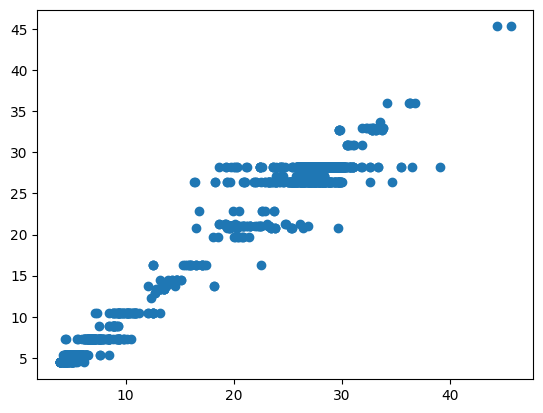

In [33]:
plt.scatter(x = y_test, y = y_pred)

# Random Forests

In [34]:
rf_model = RandomForestRegressor(n_estimators=100)
rf_model.fit(X_train, y_train)

y_pred = rf_model.predict(X_test)

mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Mean Squared Error: {mse}")
print(f"R^2 Score: {r2}")

/home/vimalkum/src/github/vimalk78/power-train/.power-model/lib64/python3.12/site-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Mean Squared Error: 0.6691072431932459
R^2 Score: 0.9923993378397837


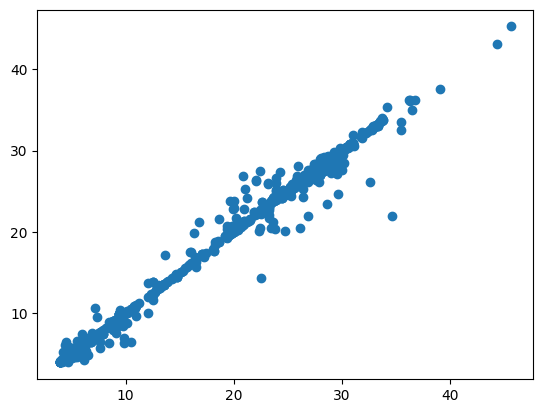

In [35]:
plt.scatter(x = y_test, y = y_pred)

#  Gradient Boosting (XGBoost)

In [36]:
gb_model = XGBRegressor()
gb_model.fit(X_train, y_train)

y_pred = gb_model.predict(X_test)

mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Mean Squared Error: {mse}")
print(f"R^2 Score: {r2}")

Mean Squared Error: 0.8166282961962015
R^2 Score: 0.9907236099243164


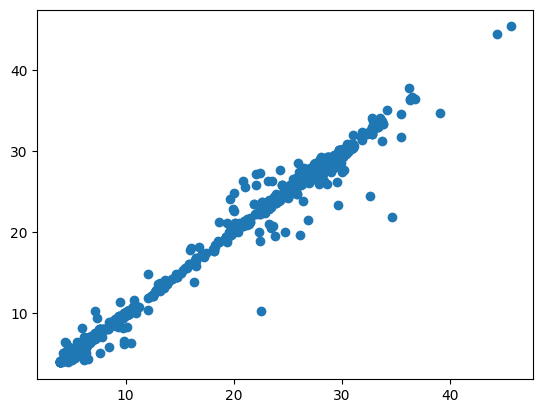

In [37]:
plt.scatter(x = y_test, y = y_pred)

# Support Vector Regression (SVR)

In [38]:
svr_model = SVR(kernel='rbf')  # Try 'poly' for polynomial kernel
svr_model.fit(X_train, y_train)

y_pred = svr_model.predict(X_test)

mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Mean Squared Error: {mse}")
print(f"R^2 Score: {r2}")

/home/vimalkum/src/github/vimalk78/power-train/.power-model/lib64/python3.12/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Mean Squared Error: 8.97834202915004
R^2 Score: 0.8980113498745507


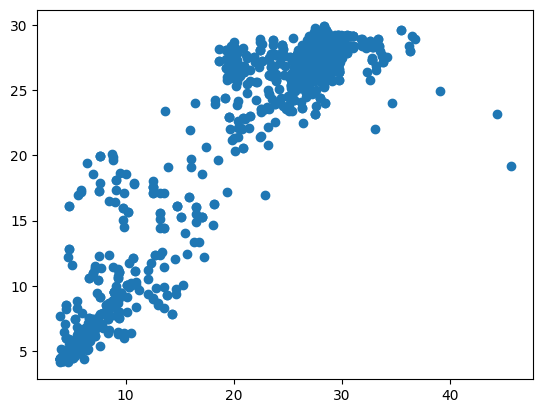

In [39]:
plt.scatter(x = y_test, y = y_pred)

# Real test here

In [138]:
end_time = datetime.now()
#end_time = datetime.fromtimestamp(1726479694)

duration = duration_2_hour

start_time = end_time - timedelta(milliseconds=duration)

In [139]:
bpf_cpu_time_df = fetch_prometheus_data(
    start_time=start_time,
    end_time=end_time,
    query=QUERY_BPF_CPU_TIME,
    rename_value_column='bpf_cpu_time',
    #label_config={"command": ".*stress.*"},
    #columns=COLUMNS_COMMAND_PID
    )
bpf_cpu_time_df.attrs = {"name": "bpf_cpu_time_df"}
#printDF(bpf_cpu_time_df)

In [140]:
rapl_pkg_joules_df = fetch_prometheus_data(
    start_time=start_time,
    end_time=end_time,
    query=QUERY_NODE_RAPL_PKG_JOULES_TOTAL,
    rename_value_column='rapl_pkg_joules',
    label_config={"path": LABEL_RAPL_PATH})
rapl_pkg_joules_df.attrs = {"name": "rapl_pkg_joules_df"}
#printDF(rapl_pkg_joules_df)

In [141]:
kepler_pkg_joules_df = fetch_prometheus_data(
    start_time=start_time,
    end_time=end_time,
    query=QUERY_KEPLER_PKG_JOULES_TOTAL,
    rename_value_column='kepler_pkg_joules',
    #label_config={"command": ".*stress.*"},
    columns=COLUMNS_COMMAND_PID)
kepler_pkg_joules_df.attrs = {"name": "kepler_pkg_joules_df"}
#printDF(kepler_pkg_joules_df)

In [142]:
cpu_inst_df = fetch_prometheus_data(
    start_time=start_time,
    end_time=end_time,
    query=QUERY_CPU_INSTRUCTIONS,
    rename_value_column='cpu_instructions',
    #label_config={"command": ".*stress.*"},
    columns=COLUMNS_COMMAND_PID)
cpu_inst_df.attrs = {"name": "cpu_inst_df"}
#printDF(cpu_inst_df)

In [143]:
cpu_cycles_df = fetch_prometheus_data(
    start_time=start_time,
    end_time=end_time,
    query=QUERY_CPU_CYCLES,
    rename_value_column='cpu_cycles',
    #label_config={"command": ".*stress.*"},
    columns=COLUMNS_COMMAND_PID)
cpu_cycles_df.attrs = {"name": "cpu_cycles_df"}    
#printDF(cpu_cycles_df)

In [144]:
cpu_scaling_freq_df = fetch_prometheus_data(
    start_time=start_time,
    end_time=end_time,
    query=QUERY_NODE_CPU_SCALING_FREQUENCY_HERTZ,
    rename_value_column='cpu_scaling_freq',
    #label_config={"command": ".*stress.*"},
    columns=COLUMNS_COMMAND_PID)
cpu_scaling_freq_df.attrs = {"name": "cpu_scaling_freq_df"}    
#printDF(cpu_scaling_freq_df)

In [145]:
X = bpf_cpu_time_df
X['cpu_instructions'] = cpu_inst_df['cpu_instructions']
X['cpu_cycles'] = cpu_cycles_df['cpu_cycles']
X['cpu_scaling_freq'] = cpu_scaling_freq_df['cpu_scaling_freq']
y_actual = pd.DataFrame(rapl_pkg_joules_df['rapl_pkg_joules'])

In [146]:
print(bpf_cpu_time_df.shape)
bpf_cpu_time_df.sample

(7201, 4)


<bound method NDFrame.sample of             bpf_cpu_time  cpu_instructions    cpu_cycles  cpu_scaling_freq
timestamp                                                                 
1726498972   1151.933333      7.430459e+08  6.696909e+08      2.093310e+10
1726498973   1151.933333      7.430459e+08  6.696909e+08      2.093310e+10
1726498974   1151.933333      7.430459e+08  6.696909e+08      2.093310e+10
1726498975   1151.933333      7.430459e+08  6.696909e+08      2.093310e+10
1726498976   1151.933333      7.430459e+08  6.696909e+08      1.635913e+10
...                  ...               ...           ...               ...
1726506168   1472.600000      1.435793e+09  1.548244e+09      1.688980e+10
1726506169   1472.600000      1.435793e+09  1.548244e+09      1.688980e+10
1726506170   1472.600000      1.435793e+09  1.548244e+09      1.688980e+10
1726506171   1472.600000      1.435793e+09  1.548244e+09      1.650289e+10
1726506172   1489.800000      1.553435e+09  1.597936e+09      1.6502

In [147]:
X.sample

<bound method NDFrame.sample of             bpf_cpu_time  cpu_instructions    cpu_cycles  cpu_scaling_freq
timestamp                                                                 
1726498972   1151.933333      7.430459e+08  6.696909e+08      2.093310e+10
1726498973   1151.933333      7.430459e+08  6.696909e+08      2.093310e+10
1726498974   1151.933333      7.430459e+08  6.696909e+08      2.093310e+10
1726498975   1151.933333      7.430459e+08  6.696909e+08      2.093310e+10
1726498976   1151.933333      7.430459e+08  6.696909e+08      1.635913e+10
...                  ...               ...           ...               ...
1726506168   1472.600000      1.435793e+09  1.548244e+09      1.688980e+10
1726506169   1472.600000      1.435793e+09  1.548244e+09      1.688980e+10
1726506170   1472.600000      1.435793e+09  1.548244e+09      1.688980e+10
1726506171   1472.600000      1.435793e+09  1.548244e+09      1.650289e+10
1726506172   1489.800000      1.553435e+09  1.597936e+09      1.6502

Model : LinearRegression
Mean Squared Error : 9.507236624491972
R^2 Score          : -0.16618874958459995
Correlation        : 0.501676


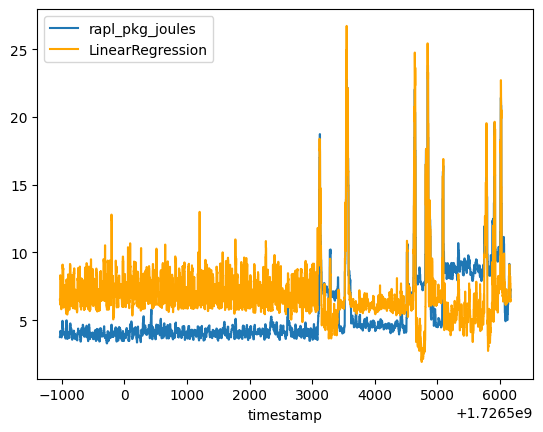

Model : PolynomialRegression
Mean Squared Error : 4.056444485458779
R^2 Score          : 0.5024232477742394
Correlation        : 0.810348


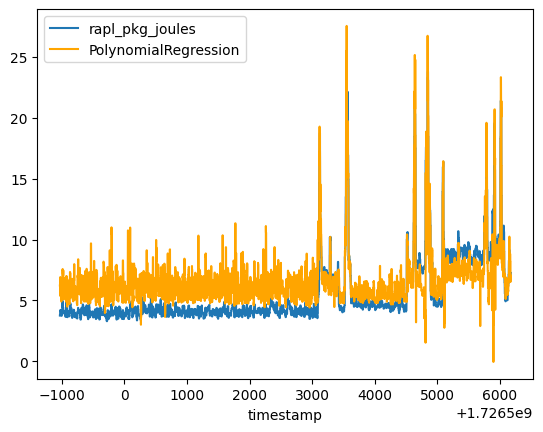

Model : LogarithmicTransformation
Mean Squared Error : 18.27461736602057
R^2 Score          : -1.2416243559474203
Correlation        : 0.781186


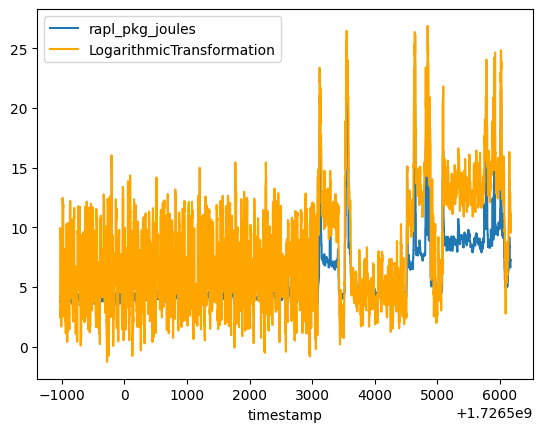

Model : DecisionTree
Mean Squared Error : 12.134131876140454
R^2 Score          : -0.4884123156750635
Correlation        : 0.741531


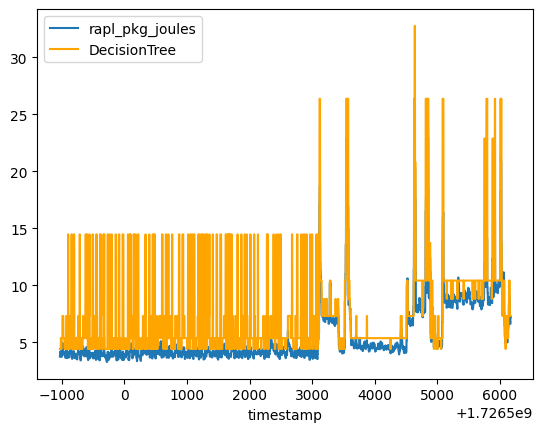

Model : RandomForest
Mean Squared Error : 10.277427088790203
R^2 Score          : -0.2606628317998336
Correlation        : 0.759114


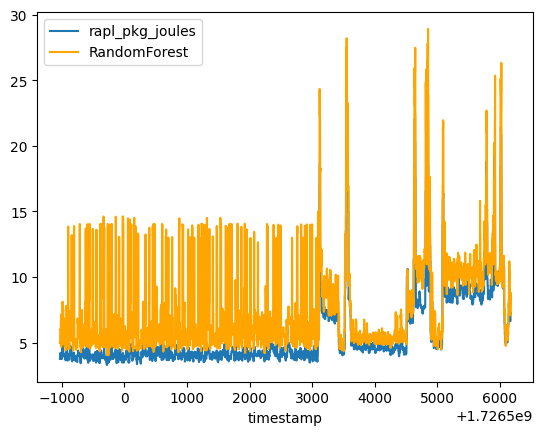

Model : XGBoost
Mean Squared Error : 5.59158570983912
R^2 Score          : 0.31411780260588096
Correlation        : 0.876608


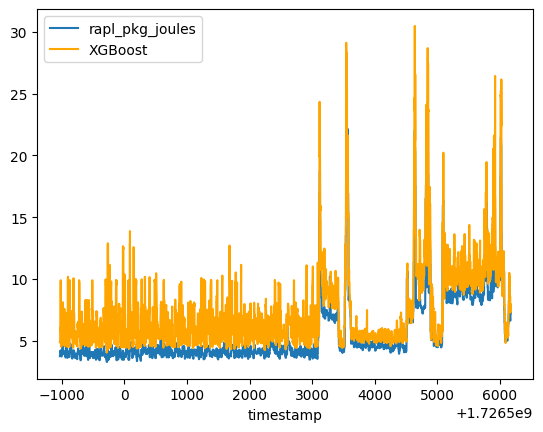

Model : SVR
Mean Squared Error : 6.615225378200756
R^2 Score          : 0.18855481179984956
Correlation        : 0.783511


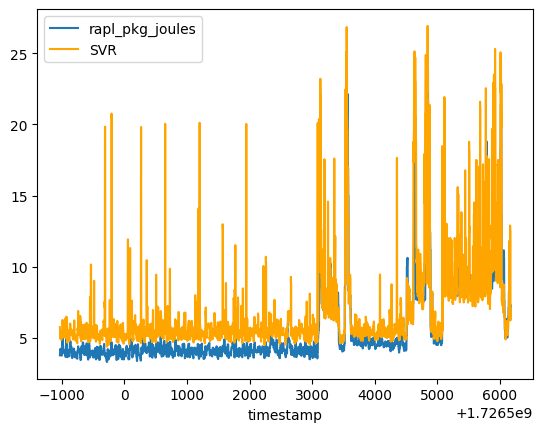

In [148]:
for model_name, model in {"LinearRegression":lr_model, "PolynomialRegression":pr_model, "LogarithmicTransformation":lt_model, "DecisionTree":dt_model, "RandomForest":rf_model, "XGBoost":gb_model, "SVR":svr_model}.items():
    ax = rapl_pkg_joules_df['rapl_pkg_joules'].plot(legend="rapl_pkg_joules")
    #ax2 = ax.twinx()
    
    x_test = X
    print(f"Model : {model_name}")
    if model_name == "LogarithmicTransformation":
        x_test = np.log(X)
    y_pred = model.predict(x_test)
    mse = mean_squared_error(rapl_pkg_joules_df['rapl_pkg_joules'], y_pred)
    r2 = r2_score(rapl_pkg_joules_df['rapl_pkg_joules'], y_pred)

    
    
    print(f"Mean Squared Error : {mse}")
    print(f"R^2 Score          : {r2}")    
    df = pd.DataFrame(y_pred, index=rapl_pkg_joules_df.index, columns=[model_name])
    corr = df.corrwith(rapl_pkg_joules_df['rapl_pkg_joules'])   
    corr_value = corr[model_name]
    print(f"Correlation        : {corr_value:4f}")
    
    df.plot(ax = ax, color="orange", legend=model_name)


    plt.legend()
    plt.show()
    